# Project: Investigating the No-Shows Medical Appointments Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The dataset used in this project is the No Shows Medical Appointments dataset from Kaggle. The dataset gathers data from doctor appointments in the hope of understanding why some people don't show up to their doctor appointments, discovering patterns that can help predict someone's behavior from pre-existing information on alcoholism, handicap, diabetes conditions and whether they affect the case of No-Show. More formally we can rearrange the issue in the following main questions:
1. What factors can be used to predict if a patient will show up for their scheduled appointment ?
2. Which gender shows up the most ?
3. Which age group shows up the most ?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

Below we load the csv dataset and take a look at the first few rows.

In [2]:
df = pd.read_csv('dataset/noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


We look at the number of rows in the dataset.

In [3]:
df.shape

(110527, 14)

We check for null values and duplicates.

In [4]:
print("{} null values.\
      \n{} duplicates."
      .format(df.isnull().any(axis=1).sum(), 
          df.duplicated().sum())
     )


0 null values.      
0 duplicates.


A few observations can be taken by looking at the first rows. PatientID and AppointmentId may not be relevant to keep as they don't serve any help. Neighbourhood also is not relevant to take into consideration as we attempt to find patterns between personal characterstics rather than by geolocation (It can help but the column itself is not enough). 

We will address these issues in more details in the following section.

### Data Cleaning

In [5]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


We start by droping the unnecessary columns.

In [6]:
df.drop(columns=['PatientId', 'AppointmentID', 'Neighbourhood'], inplace=True)
df.head()

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,0,0,No
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,0,0,0,0,0,0,No
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,0,0,0,0,0,0,No
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,0,0,0,0,0,0,No
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,0,1,1,0,0,0,No


Some columns seems to be grammatically incorrect, let's fix that.

In [7]:
df.rename(columns={"Hipertension": "Hypertension", "Handcap": "Handicap", "SMS_received": "SMSReceived", "No-show": "NoShow"}, inplace=True)

Now, let's take a look at the data types.

In [8]:
df.dtypes

Gender            object
ScheduledDay      object
AppointmentDay    object
Age                int64
Scholarship        int64
Hypertension       int64
Diabetes           int64
Alcoholism         int64
Handicap           int64
SMSReceived        int64
NoShow            object
dtype: object

Many inconsistencies can be addressed:
1. ScheduledDay & AppointmentDay should be a date (We don't need the time part).
2. Scholarship, Hipertension, Diabetes, Alcoholism and SMS_received are all Yes/No columns, it's better to change the data types to object just like No-show (Handicap is not a binary column but it describes a level from 0 to 4).

Let's do that.

In [9]:
# Changing ScheduledDay & AppointmentDay to datetime64 keeping only the date part
df.ScheduledDay = pd.to_datetime(df.ScheduledDay).dt.date.astype("datetime64")
df.AppointmentDay = pd.to_datetime(df.AppointmentDay).dt.date.astype('datetime64')

# Changing data type to object
df.Scholarship = df.Scholarship.astype(str)
df.Hypertension = df.Hypertension.astype(str)
df.Diabetes = df.Diabetes.astype(str)
df.Alcoholism = df.Alcoholism.astype(str)
df.Handicap = df.Handicap.astype(str)
df.SMSReceived = df.SMSReceived.astype(str)

# Replacing (0,1) values with (No,Yes)
df.Scholarship.replace({"0": "No", "1": "Yes"}, inplace=True)
df.Hypertension.replace({"0": "No", "1": "Yes"}, inplace=True)
df.Diabetes.replace({"0": "No", "1": "Yes"}, inplace=True)
df.Alcoholism.replace({"0": "No", "1": "Yes"}, inplace=True)
df.SMSReceived.replace({"0": "No", "1": "Yes"}, inplace=True)

In [10]:
df.head()

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
0,F,2016-04-29,2016-04-29,62,No,Yes,No,No,0,No,No
1,M,2016-04-29,2016-04-29,56,No,No,No,No,0,No,No
2,F,2016-04-29,2016-04-29,62,No,No,No,No,0,No,No
3,F,2016-04-29,2016-04-29,8,No,No,No,No,0,No,No
4,F,2016-04-29,2016-04-29,56,No,Yes,Yes,No,0,No,No


Just the way we want it!

Now, let's dig deeper in the values of each column. Since the Yes/No columns were modified previously, let's make sure there is no other value that wasn't catched when calling the replace() method.

In [11]:
for column in df.columns:
    if(column not in ['ScheduledDay', 'AppointmentDay', 'Age']):
        print(f"Unique values of {column} are: {df[column].unique()}")

Unique values of Gender are: ['F' 'M']
Unique values of Scholarship are: ['No' 'Yes']
Unique values of Hypertension are: ['Yes' 'No']
Unique values of Diabetes are: ['No' 'Yes']
Unique values of Alcoholism are: ['No' 'Yes']
Unique values of Handicap are: ['0' '1' '2' '3' '4']
Unique values of SMSReceived are: ['No' 'Yes']
Unique values of NoShow are: ['No' 'Yes']


It's looks like the columns above are clean, and the unique values are relevent.

We look now at the Age column for any unusual value. For that, we use look at the value counts in sorted indexes.

In [12]:
df.Age.value_counts().sort_index()

-1         1
 0      3539
 1      2273
 2      1618
 3      1513
        ... 
 98        6
 99        1
 100       4
 102       2
 115       5
Name: Age, Length: 104, dtype: int64

We find an unusual 'Age = -1' value which we can simply drop. Other values of age seems reasonable.

In [13]:
df.query("Age == -1")

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
99832,F,2016-06-06,2016-06-06,-1,No,No,No,No,0,No,No


In [14]:
df = df[df.Age >= 0]

<a id='eda'></a>
## Exploratory Data Analysis

### Understanding the Dataset:

#### 1. Gender

Let's look at the dominant gender in our dataset.

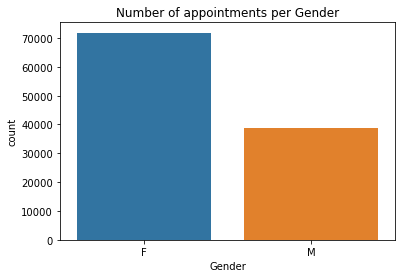

In [16]:
sns.countplot(x='Gender', data=df)
plt.title("Number of appointments per Gender");

In [17]:
print("{data[F]}% of appointments belongs to females.\
      \n{data[M]}% of appointments belongs to males."
      .format(data=(df.Gender.value_counts() / df.shape[0]).apply(lambda x: round(x*100, 2))))

65.0% of appointments belongs to females.      
35.0% of appointments belongs to males.


#### 2. Age

We start off by a simple historgram of age.

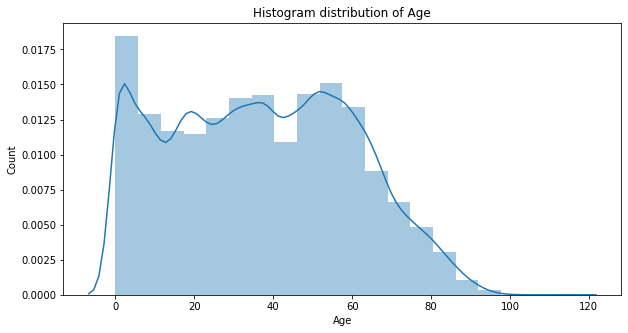

In [18]:
plt.figure(figsize=(10,5))
sns.distplot(df.Age, bins=20)
plt.ylabel('Count')
plt.title('Histogram distribution of Age');

The distribution seems to be right skewed. Let's look at Box plot of Age.

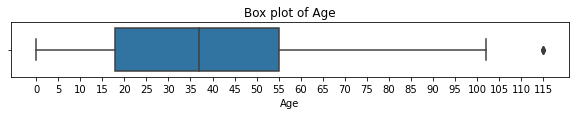

In [19]:
plt.figure(figsize=(10,1))
sns.boxplot(x='Age', data=df)
plt.xticks(np.arange(0, 120, 5))
plt.title("Box plot of Age");

The box plot shows outliers at the age of 115, which can be ignored since they are not really unusual values.

#### 3. Scholarship

We look at the bar plot of Scholarship.

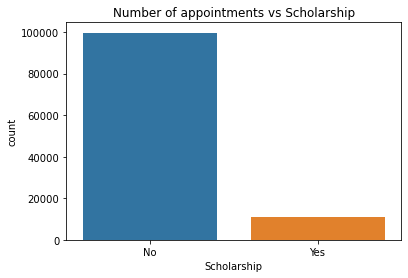

In [20]:
sns.countplot(x='Scholarship', data=df)
plt.title("Number of appointments vs Scholarship");

In [21]:
print("{data[No]}% of appointments belongs to patients without a scholarship.\
      \n{data[Yes]}% of appointments belongs to patients with a scholarship."
      .format(data=(df.Scholarship.value_counts() / df.shape[0]).apply(lambda x: round(x*100, 2))))

90.17% of appointments belongs to patients without a scholarship.      
9.83% of appointments belongs to patients with a scholarship.


#### 4. Hypertension

We look at the bar plot of Hypertension.

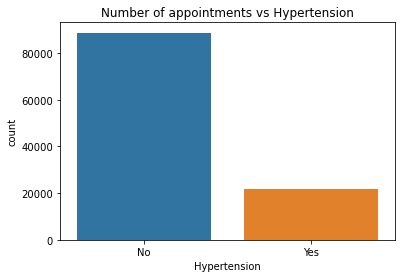

In [22]:
sns.countplot(x='Hypertension', data=df, order=['No', 'Yes'])
plt.title("Number of appointments vs Hypertension");

In [23]:
print("{data[No]}% of appointments belongs to patients without hypertension.\
      \n{data[Yes]}% of appointments belongs to patients with hypertension."
      .format(data=(df.Hypertension.value_counts() / df.shape[0]).apply(lambda x: round(x*100, 2))))

80.28% of appointments belongs to patients without hypertension.      
19.72% of appointments belongs to patients with hypertension.


#### 5. Diabetes

We look at the bar plot of Diabetes.

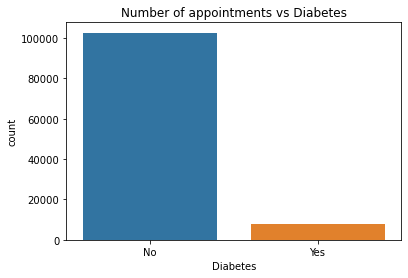

In [24]:
sns.countplot(x='Diabetes', data=df)
plt.title("Number of appointments vs Diabetes");

In [25]:
print("{data[No]}% of appointments belongs to patients without diabetes.\
      \n{data[Yes]}% of appointments belongs to patients with diabetes."
      .format(data=(df.Diabetes.value_counts() / df.shape[0]).apply(lambda x: round(x*100, 2))))

92.81% of appointments belongs to patients without diabetes.      
7.19% of appointments belongs to patients with diabetes.


#### 6. Alcoholism

We look at the bar plot of Alcoholism.

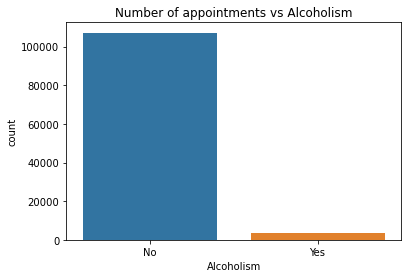

In [26]:
sns.countplot(x='Alcoholism', data=df)
plt.title("Number of appointments vs Alcoholism");

In [27]:
print("{data[No]}% of appointments belongs to patients without alcoholism.\
      \n{data[Yes]}% of appointments belongs to patients with alcoholism."
      .format(data=(df.Alcoholism.value_counts() / df.shape[0]).apply(lambda x: round(x*100, 2))))

96.96% of appointments belongs to patients without alcoholism.      
3.04% of appointments belongs to patients with alcoholism.


#### 7. Handicap

We look at the bar plot of Handicap.

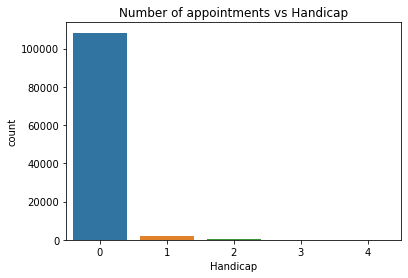

In [28]:
sns.countplot(x='Handicap', data=df)
plt.title("Number of appointments vs Handicap");

In [29]:
print("{data[0]}% of appointments belongs to patients with handicap level 0.\
      \n{data[1]}% of appointments belongs to patients with handicap level 1.\
      \n{data[2]}% of appointments belongs to patients with handicap level 2.\
      \n{data[3]}% of appointments belongs to patients with handicap level 3.\
      \n{data[4]}% of appointments belongs to patients with handicap level 4."
      .format(data=(df.Handicap.value_counts() / df.shape[0]).apply(lambda x: round(x*100, 3))))

97.972% of appointments belongs to patients with handicap level 0.      
1.848% of appointments belongs to patients with handicap level 1.      
0.166% of appointments belongs to patients with handicap level 2.      
0.012% of appointments belongs to patients with handicap level 3.      
0.003% of appointments belongs to patients with handicap level 4.


#### 8. SMSReceived

We look at the bar plot of SMSReceived.

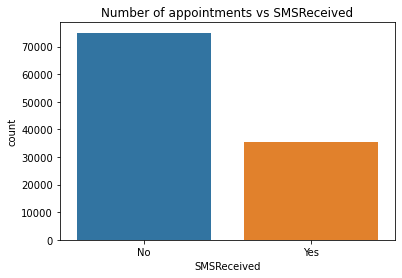

In [30]:
sns.countplot(x='SMSReceived', data=df)
plt.title("Number of appointments vs SMSReceived");

In [31]:
print("{data[No]}% of appointments belongs to patients who didn't receive an SMS.\
      \n{data[Yes]}% of appointments belongs to patients who received an SMS."
      .format(data=(df.SMSReceived.value_counts() / df.shape[0]).apply(lambda x: round(x*100, 2))))

67.9% of appointments belongs to patients who didn't receive an SMS.      
32.1% of appointments belongs to patients who received an SMS.


#### 9. NoShow

##### Note: 'No' value means the patient showed up to his/her scheduled appointment, while 'Yes' value means he/she didn't.

We look at the bar plot of NoShow.

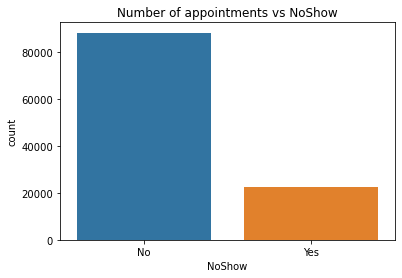

In [32]:
sns.countplot(x='NoShow', data=df)
plt.title("Number of appointments vs NoShow");

In [33]:
print("{data[No]}% of appointments belongs to patients who showed up to their scheduled appointment.\
      \n{data[Yes]}% of appointments belongs to patients who didn't show up to their scheduled appointment."
      .format(data=(df.NoShow.value_counts() / df.shape[0]).apply(lambda x: round(x*100, 2))))

79.81% of appointments belongs to patients who showed up to their scheduled appointment.      
20.19% of appointments belongs to patients who didn't show up to their scheduled appointment.


### Research Question 1 : What factors can be used to predict if a patient will show up for their scheduled appointment ?

To answer the question, we need to look at the different columns (the independent variables) of the dataset to find any relationship with the NoShow column (the independent variable).

#### 1. Gender

We create a stacked bar plot of the ratio of NoShow by Gender.

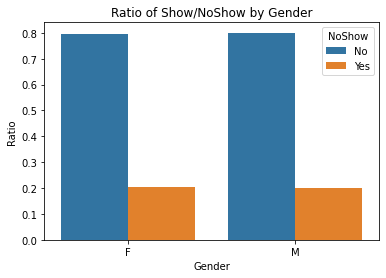

In [34]:
data = pd.DataFrame(df.groupby(['Gender', 'NoShow']).size() / df.groupby('Gender').size(), 
                    columns=['Ratio']).reset_index()
g = sns.barplot(x='Gender', y='Ratio', hue='NoShow', data=data)
plt.title("Ratio of Show/NoShow by Gender");

Looking at the plot, it seems like both genders are having the same ratio, whether they showed up on schedule (Approx. 80% of the time), or they didn't (Approx. 20% of the time).

This means the gender may not be a useful information to predict the patient's behavior.

#### 2. Age

We create a stacked bar plot of the ratio of NoShow by Age.

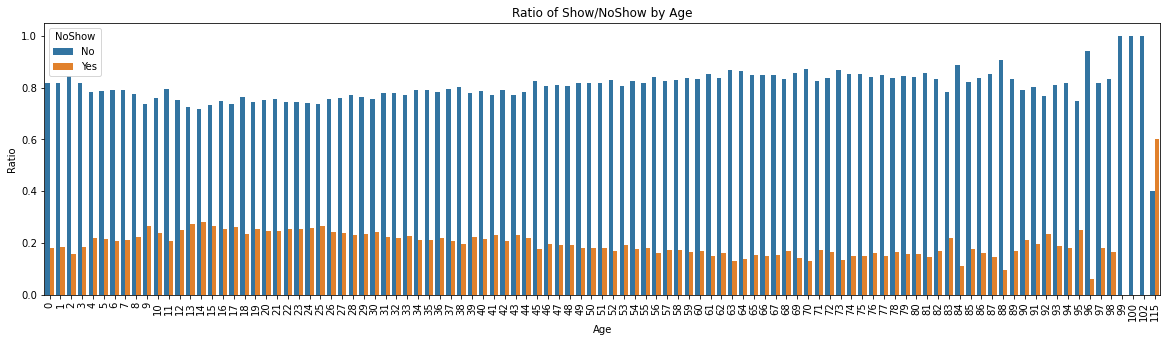

In [35]:
plt.figure(figsize=(20,5))
data = pd.DataFrame(df.groupby(['Age', 'NoShow']).size() / df.groupby('Age').size(), columns=['Ratio']).reset_index()
g = sns.barplot(x='Age', y='Ratio', hue='NoShow', data=data)
plt.title("Ratio of Show/NoShow by Age")
plt.xticks(rotation=90);

Looking at the ratio of NoShow by age, around 80% of patients of all all ages show up on there scheduled appointment, while around 20% of them don't.

There is an unsignificant exception of 100% show rate for people between the age of 99 and 102, which we can ignore for now, since they form a minority group and we probably need more data about them to have more accurate analysis on them.

Again, the Age column doesn't seem to be helpful when predicting NoShow accurately.

#### 3. Scholarship

We look at the stacked bar plot of ratio of NoShow vs Scholarship.

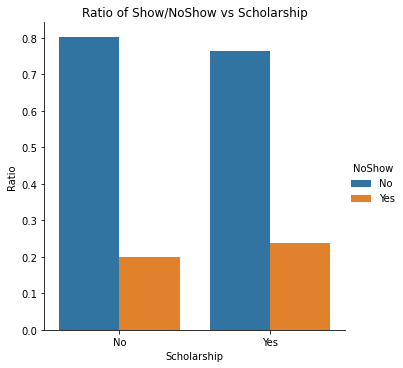

In [36]:
data = pd.DataFrame(df.groupby(['Scholarship', 'NoShow']).size() / df.groupby('Scholarship').size(), columns=['Ratio']).reset_index()
g = sns.catplot(x='Scholarship', y='Ratio', hue='NoShow', data=data, kind='bar', legend=True)
plt.title("Ratio of Show/NoShow vs Scholarship");

It looks like the patients with a Scholarship program seems to have lower show rate than people without a Scholarship program. These feature can be relied on when making machine learning models.

#### 4. Hypertension

We look at the stacked bar plot of ratio of NoShow vs Hypertension.

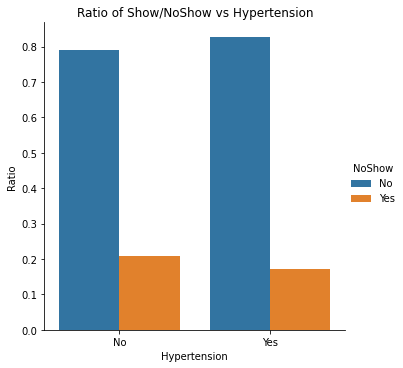

In [37]:
data = pd.DataFrame(df.groupby(['Hypertension', 'NoShow']).size() / df.groupby('Hypertension').size(), columns=['Ratio']).reset_index()
g = sns.catplot(x='Hypertension', y='Ratio', hue='NoShow', data=data, kind='bar', legend=True)
plt.title("Ratio of Show/NoShow vs Hypertension");

The stacked bar plot shows a higher show rate for people with Hypertension condition. This feature can add more accuracy when making predictions.

#### 5. Diabetes

We look at the stacked bar plot of ratio of NoShow vs Diabetes.

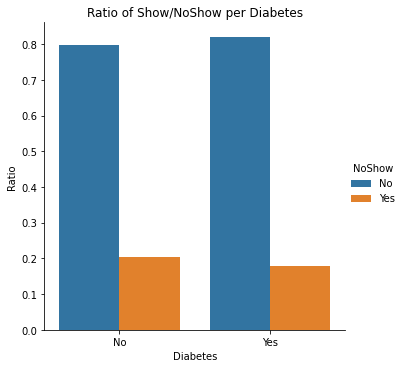

In [38]:
data = pd.DataFrame(df.groupby(['Diabetes', 'NoShow']).size() / df.groupby('Diabetes').size(), columns=['Ratio']).reset_index()
g = sns.catplot(x='Diabetes', y='Ratio', hue='NoShow', data=data, kind='bar', legend=True)
plt.title("Ratio of Show/NoShow per Diabetes");

People with a Diabetes condition showed a slightly higher show rate than people without Diabetes. We can use this property when making predictions.

#### 7. Alcoholism

We look at the stacked bar plot of ratio of NoShow vs Alcoholism.

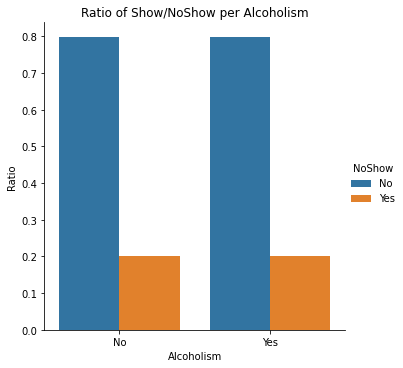

In [39]:
data = pd.DataFrame(df.groupby(['Alcoholism', 'NoShow']).size() / df.groupby('Alcoholism').size(), columns=['Ratio']).reset_index()
g = sns.catplot(x='Alcoholism', y='Ratio', hue='NoShow', data=data, kind='bar', legend=True)
plt.title("Ratio of Show/NoShow per Alcoholism");

It is quite clear that Alcoholism is not a good predictor of NoShow since both groups are having the same show/no-show rate.

#### 8. Handicap

We look at the stacked bar plot of ratio of NoShow vs Handicap.

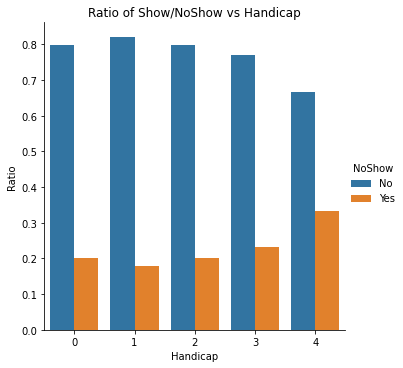

In [40]:
data = pd.DataFrame(df.groupby(['Handicap', 'NoShow']).size() / df.groupby('Handicap').size(), columns=['Ratio']).reset_index()
g = sns.catplot(x='Handicap', y='Ratio', hue='NoShow', data=data, kind='bar', legend=True)
plt.title("Ratio of Show/NoShow vs Handicap");

Looking at the different Handicap levels, patients with level 4 scored the lowest show rate, followed by people with level 3. Patients with level 0 and 2 scored the same show rate, while patients with level 1 scored the highest show rate.

This feature can help us determining someone's behavior.

#### 9. SMSReceived

We look at the stacked bar plot of ratio of NoShow vs SMSReceived.

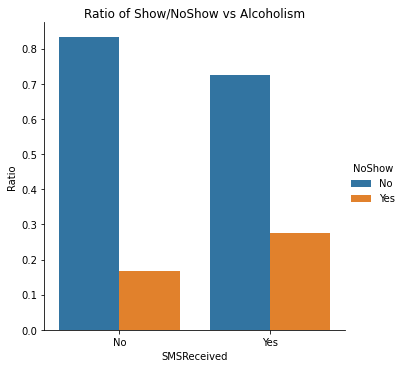

In [41]:
data = pd.DataFrame(df.groupby(['SMSReceived', 'NoShow']).size() / df.groupby('SMSReceived').size(), columns=['Ratio']).reset_index()
g = sns.catplot(x='SMSReceived', y='Ratio', hue='NoShow', data=data, kind='bar', legend=True)
plt.title("Ratio of Show/NoShow vs Alcoholism");

As this feature seems quite useful, the results shown are strange and not intuitive. It shows that patients who received an SMS notification scored a lower show rate than patients who weren't notified. 

Nonetheless, it's important to keep this feature when making predictions.

#### 10. ScheduledDay

We create a stacked bar plot of the ratio of NoShow vs the scheduled day of week.

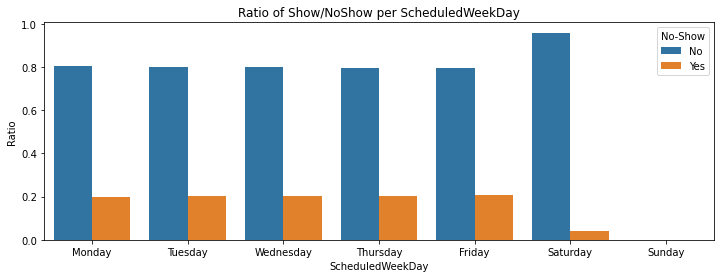

In [42]:
data = df[['ScheduledDay', 'NoShow']].copy()
data['ScheduledWeekDay'] = data.ScheduledDay.dt.weekday
data.drop(columns=['ScheduledDay'], inplace=True)
data.ScheduledWeekDay.replace({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}, inplace=True)
data = pd.DataFrame(data.groupby(['ScheduledWeekDay', 'NoShow']).size() / data.groupby('ScheduledWeekDay').size(), columns=['Ratio']).reset_index()
plt.figure(figsize=(12,4))
g = sns.barplot(x='ScheduledWeekDay', y='Ratio', hue='NoShow', data=data, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])
plt.title("Ratio of Show/NoShow per ScheduledWeekDay")
plt.legend(title='No-Show', loc='upper right');

It is clear that appointments on Saturday are having the highest show rate, while on working days it is lower but equivalent. This feature can be useful for us.

### Research Question 2 : Which gender shows up the most ?

Using the count plot of Gender as well as the stacked bar plot of NoShow vs Gender below.

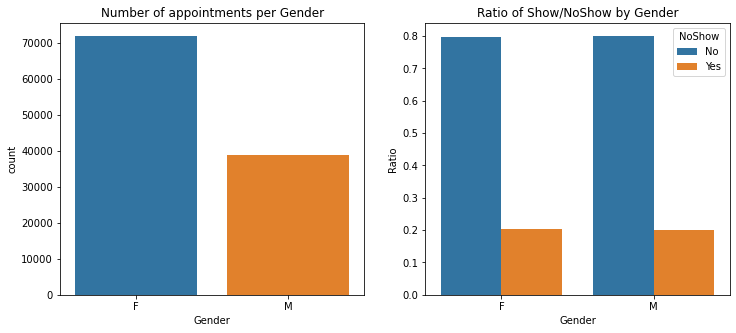

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.countplot(x='Gender', data=df, ax=axes[0])
axes[0].set_title("Number of appointments per Gender")

data = pd.DataFrame(df.groupby(['Gender', 'NoShow']).size() / df.groupby('Gender').size(), 
                    columns=['Ratio']).reset_index()
sns.barplot(x='Gender', y='Ratio', hue='NoShow', data=data, ax=axes[1])
axes[1].set_title("Ratio of Show/NoShow by Gender");

Looking at the count plot of Gender, we observe more appointments belonging to females. However, the stacked bar plot shows despite the count differences, both genders are having the same show rate.

### Research Question 3 : Which age group shows up the most ?

Let's look at the count plot of age.

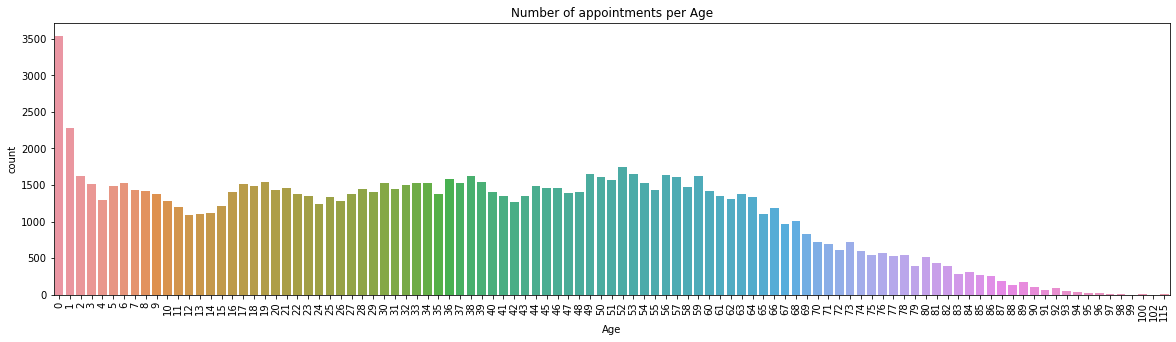

In [44]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x='Age', data=df)
ax.set_title("Number of appointments per Age")
plt.xticks(rotation=90);

The count plot above shows that patients under age of 2 are having more doctor appointments, while people above the age of 64 are having less doctor appointments.

However, we need to look at the show rate to understand more.

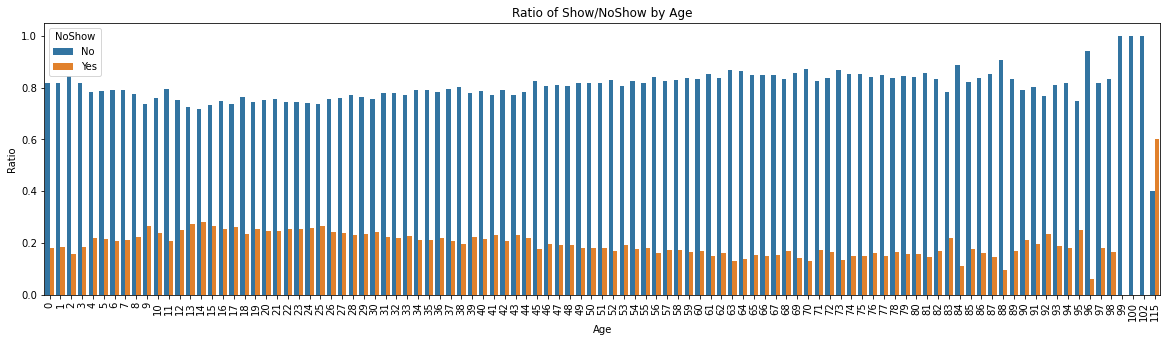

In [45]:
plt.figure(figsize=(20,5))
data = pd.DataFrame(df.groupby(['Age', 'NoShow']).size() / df.groupby('Age').size(), columns=['Ratio']).reset_index()
g = sns.barplot(x='Age', y='Ratio', hue='NoShow', data=data)
plt.title("Ratio of Show/NoShow by Age")
plt.xticks(rotation=90);

The show rate of all patients is almost the same (75% on average) except for age range between 99 and 102 having 100% show rate, as well as patients with age 115 having the lowest show rate (below 40%).

<a id='conclusions'></a>
## Conclusions

The study was conducted on the NoShow Medical Appointments dataset. Some of the key points discussed were about the main factors that affect the show rate and can be used to determine whether a patient will show up to his/her scheduled appointment. The top factors that were found are: Hypertension, Diabetes, Handicap, Scholarship, and SMSReceived.

#### Limitations

During the Exploratory Data Analysis phase, many issues and doubts were affecting our ability to make accurate decisions on whether the features will predict NoShow accurately or not. Some of the limitations of the dataset are:
* The need for more information about employment and working hours to know whether the patients are busy when the scheduled appointment day arrives.
* The SMSReceived non trivial results needs to be investigated further. It would be helpful to know how familiar are the patients with the use of cellphones.
* We need more information about the type of appointment and what it is about. This helps to know what types of appointments are being missing (we can assume the less urgent ones will be missed more).
It is clear that the dataset is not enough to make serious accurate predictions and we need more data about each patient, and the specialization of the doctor.

#### References

N/A